In [52]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from pylab import *
import os
import pickle
import pandas as pd
import numpy as np
from paretoset import paretoset
import torch

import loss_landscapes
import loss_landscapes.metrics

# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
import autoencoder_datamodule as ae

In [53]:
precision = 9
# load the model
model = AutoEncoder(
    quantize=(precision < 32),
    precision=[
        precision,
        precision,
        precision+3
    ],
    learning_rate=learning_rate,
    econ_type="baseline"
)

# to set the map location
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model(torch.randn((1, 1, 8, 8)).to(device))  # Update tensor shapes 
model_param = torch.load("/data/tbaldi/work/checkpoint/bs1024_lr0.0015625/ECON_JREG_9b/baseline/net_1_0.5_best-v1.pkl", map_location=device)
model.load_state_dict(model_param['state_dict'])


<All keys matched successfully>

In [54]:
data_module = ae.get_data_module("/data/tbaldi/work/loss_landscape_taxonomy/data/ECON/Elegun", "nELinks5.npy", 1024, 2)
_, dataloader = data_module.dataloaders()
criterion = model.loss
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)
loss_data = loss_landscapes.random_plane(model,
                                         metric,
                                         150,
                                         100,
                                         normalization="filter",
                                         deepcopy_model=False)

/tmp/tbaldi/ipykernel_1828674/341838716.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


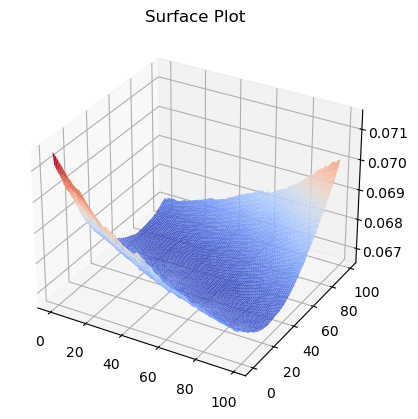

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(100)] for i in range(100)])
Y = np.array([[i for _ in range(100)] for i in range(100)])
ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title(f'Surface Plot')
fig.show()

# Models Training Status

In this notebook there are scripts to check which models are there and which are missing.

In [56]:
base_path = "/home/jovyan/checkpoint/"
sizes = ['small', 'baseline', 'large']
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [57]:
missing = []
def get_missing_econ(bs, lr, precision):
    missing = []
    for size in sizes:
        # print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
        for exp in range(1, 4):
            file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
            try:
                with open(file_path, 'r') as file:
                    content = file.read()

            except Exception as e:
                if size == 'large':
                    missing.append((bs, lr, precision))
                    continue
    return set(missing)


In [58]:
missing = {}
for bs in batch_sizes:
    
    print(f'=========== {bs} ==========')
    for lr in learning_rates:
        print(f'---------- {lr} ---------')
        for precision in precisions:
            mis = get_missing_econ(bs, lr, precision)
            if mis:
                print(f'{bs} - {lr} - {precision}')
            

=========== 16 ==========
---------- 0.1 ---------
16 - 0.1 - 2
16 - 0.1 - 3
16 - 0.1 - 4
16 - 0.1 - 5
16 - 0.1 - 6
16 - 0.1 - 7
16 - 0.1 - 8
16 - 0.1 - 9
16 - 0.1 - 10
16 - 0.1 - 11
---------- 0.05 ---------
16 - 0.05 - 2
16 - 0.05 - 3
16 - 0.05 - 4
16 - 0.05 - 5
16 - 0.05 - 6
16 - 0.05 - 7
16 - 0.05 - 8
16 - 0.05 - 9
16 - 0.05 - 10
16 - 0.05 - 11
---------- 0.025 ---------
16 - 0.025 - 2
16 - 0.025 - 3
16 - 0.025 - 4
16 - 0.025 - 5
16 - 0.025 - 6
16 - 0.025 - 7
16 - 0.025 - 8
16 - 0.025 - 9
16 - 0.025 - 10
16 - 0.025 - 11
---------- 0.0125 ---------
16 - 0.0125 - 2
16 - 0.0125 - 3
16 - 0.0125 - 4
16 - 0.0125 - 5
16 - 0.0125 - 6
16 - 0.0125 - 7
16 - 0.0125 - 8
16 - 0.0125 - 9
16 - 0.0125 - 10
16 - 0.0125 - 11
---------- 0.00625 ---------
16 - 0.00625 - 2
16 - 0.00625 - 3
16 - 0.00625 - 4
16 - 0.00625 - 5
16 - 0.00625 - 6
16 - 0.00625 - 7
16 - 0.00625 - 8
16 - 0.00625 - 9
16 - 0.00625 - 10
16 - 0.00625 - 11
---------- 0.003125 ---------
16 - 0.003125 - 2
16 - 0.003125 - 3
16 - 0.003125

In [59]:
missing = []
def get_missing_econ(bs, lr, precision):
    missing = []
    for size in sizes:
        # print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
        for exp in range(1, 6):
            file_path = base_path + f'bs{bs}_lr{lr}/JTAG_{precision}b/accuracy_{exp}.txt'
            try:
                with open(file_path, 'r') as file:
                    content = file.read()

            except Exception as e:
                missing.append((bs, lr, precision))
                continue
    return set(missing)

In [60]:
missing = {}
for bs in batch_sizes:
    
    print(f'=========== {bs} ==========')
    for lr in learning_rates:
        print(f'---------- {lr} ---------')
        for precision in precisions:
            mis = get_missing_econ(bs, lr, precision)
            if mis:
                print(f'{bs} - {lr} - {precision}')

=========== 16 ==========
---------- 0.1 ---------
16 - 0.1 - 2
16 - 0.1 - 3
16 - 0.1 - 4
16 - 0.1 - 5
16 - 0.1 - 6
16 - 0.1 - 7
16 - 0.1 - 8
16 - 0.1 - 9
16 - 0.1 - 10
16 - 0.1 - 11
---------- 0.05 ---------
16 - 0.05 - 2
16 - 0.05 - 3
16 - 0.05 - 4
16 - 0.05 - 5
16 - 0.05 - 6
16 - 0.05 - 7
16 - 0.05 - 8
16 - 0.05 - 9
16 - 0.05 - 10
16 - 0.05 - 11
---------- 0.025 ---------
16 - 0.025 - 2
16 - 0.025 - 3
16 - 0.025 - 4
16 - 0.025 - 5
16 - 0.025 - 6
16 - 0.025 - 7
16 - 0.025 - 8
16 - 0.025 - 9
16 - 0.025 - 10
16 - 0.025 - 11
---------- 0.0125 ---------
16 - 0.0125 - 2
16 - 0.0125 - 3
16 - 0.0125 - 4
16 - 0.0125 - 5
16 - 0.0125 - 6
16 - 0.0125 - 7
16 - 0.0125 - 8
16 - 0.0125 - 9
16 - 0.0125 - 10
16 - 0.0125 - 11
---------- 0.00625 ---------
16 - 0.00625 - 2
16 - 0.00625 - 3
16 - 0.00625 - 4
16 - 0.00625 - 5
16 - 0.00625 - 6
16 - 0.00625 - 7
16 - 0.00625 - 8
16 - 0.00625 - 9
16 - 0.00625 - 10
16 - 0.00625 - 11
---------- 0.003125 ---------
16 - 0.003125 - 2
16 - 0.003125 - 3
16 - 0.003125